In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import os
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

#for visualization
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [71]:
#read csv file
df = pd.read_csv('Churn_Modelling.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


### Data Cleaning

In [72]:
#drop customer id, rownumber, surname
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)

#Change gender to 1/0
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# Assign 1,2,3 to France , Germany and Spain
df["Geography"] = df["Geography"].replace({"France":1,"Germany":2,"Spain":3})

In [73]:
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
target_col = ['Exited']
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
exclude_col = ['Geography','Tenure','NumOfProducts']
HR_col = [i for i in df.columns if i not in bin_cols + target_col+ exclude_col]

for col in HR_col:
    df[col] = df[col].astype(float)
    df[[col]] = scaler.fit_transform(df[[col]])
df['Exited'] = pd.to_numeric(df['Exited'], downcast='float')
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2.69,1,0,1.621622,2,0.000000,1,1,1,2.533674,1.0
1,2.58,3,0,1.554054,1,1.670157,1,0,1,2.813544,0.0
2,1.52,1,0,1.621622,8,3.181786,3,1,0,2.848272,1.0
3,3.49,1,0,1.418919,1,0.000000,2,0,0,2.345600,0.0
4,5.00,3,0,1.689189,2,2.501231,1,1,1,1.977002,0.0


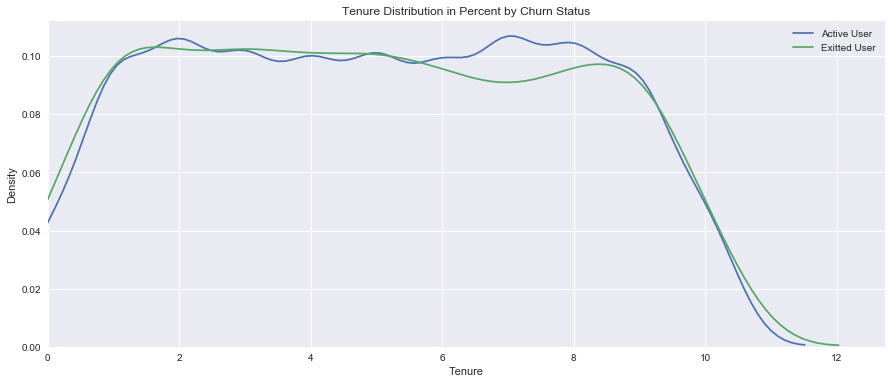

In [74]:
#To See the Tenure Distribution of active and churned User
plt.figure(figsize=(15,6))
plt.style.use('seaborn')
plt.grid(True, alpha=1)
sns.kdeplot(df.loc[df['Exited'] == 0, 'Tenure'], label = 'Active User')
sns.kdeplot(df.loc[df['Exited'] == 1, 'Tenure'], label = 'Exitted User')
plt.xlabel('Tenure')
plt.xlim(left=0)
plt.ylabel('Density')
plt.title('Tenure Distribution in Percent by Churn Status');

In [75]:
#Function to populate new columns based on the Tenure Column
def tenure_lab(df) :
    
    if df["Tenure"] <= 2 :
        return "Tenure_0-2"
    elif (df["Tenure"] > 2) & (df["Tenure"] <= 7 ):
        return "Tenure_2-7"
    elif (df["Tenure"] > 7) & (df["Tenure"] <= 13) :
        return "Tenure_7-13"
df["Tenure_group"] = df.apply(lambda df:tenure_lab(df),axis = 1)


In [76]:
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + exclude_col ]
multi_cols = [i for i in cat_cols if i not in bin_cols]

df = pd.get_dummies(data = df,columns = multi_cols )
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [77]:
df= df.drop(['Tenure'],axis=1)
df_telcom_og = df.copy()

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

#split train and test dataframe
train,test = train_test_split(df,test_size = .25 ,random_state = 111)

##seperating dependent and independent variables
cols    = [i for i in df.columns if i not in target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

In [79]:
def churnPrediction(algorithm,training_x,testing_x,training_y,testing_y,cols,cf,threshold_plot) :
    
    # model .fit() and training
    algorithm.fit(training_x,training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)

#-----------------------------------Generating Report of the Model---------------------------------------------------------------
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
#-------------------------------------------Plot Confusion Matrix--------------------------------------------------------

    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
#-------------------------------------------Plot ROC and AUC graph--------------------------------------------------------
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
#---------------------------------------fetaures importance graph--------------------------------------------------------
    # coeff(cf) => Coefficients for Logistic regression and Features for Tree Decision Model
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
#----------------------------------------------------------------------------------------------------------------------------
    
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    #-----------Plot Threshold Graph------------------------------------------
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      1982
         1.0       0.69      0.35      0.46       518

    accuracy                           0.83      2500
   macro avg       0.77      0.65      0.68      2500
weighted avg       0.82      0.83      0.81      2500

Accuracy   Score :  0.832
Area under curve :  0.6530589981649517 



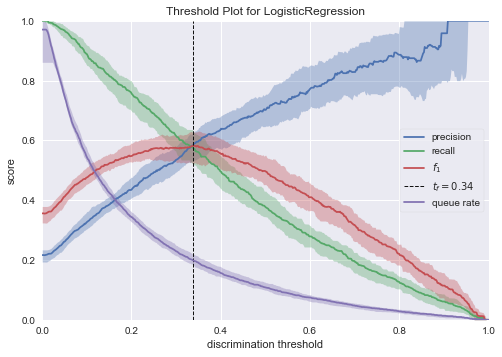

In [80]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#------------------Logistic Regression Parameters---------------------------------------------------
#  class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
#  C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,
#  solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False,
#  n_jobs=None, l1_ratio=None)[source]
#----------------------------------------------------------------------------------------------------

churnPrediction(logit,train_X,test_X,train_Y,test_Y,cols,"coefficients",threshold_plot = True)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1982
         1.0       0.45      0.74      0.56       518

    accuracy                           0.76      2500
   macro avg       0.69      0.75      0.70      2500
weighted avg       0.82      0.76      0.78      2500

Accuracy   Score :  0.7604
Area under curve :  0.7533506188904775 



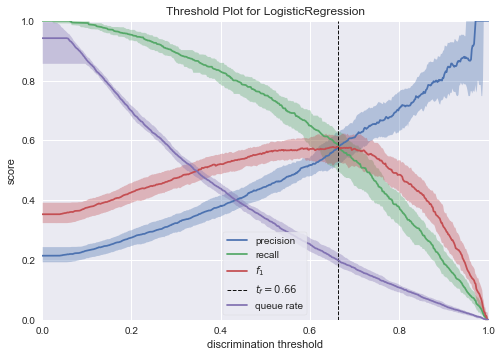

In [81]:
#Logistic Regression Variation from other example (Variation B)

logitB= LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

churnPrediction(logitB,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1982
         1.0       0.46      0.74      0.56       518

    accuracy                           0.76      2500
   macro avg       0.69      0.75      0.70      2500
weighted avg       0.82      0.76      0.78      2500

Accuracy   Score :  0.7628
Area under curve :  0.7548642414939084 



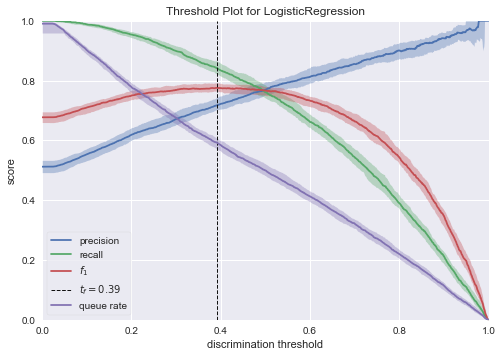

In [82]:
##SMOTE
from imblearn.over_sampling import SMOTE
cols    = [i for i in df.columns if i not in target_col]

#don't smote directly, smote on the splitted dataframe
smote_X = df[cols]
smote_Y = df[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,test_size = .25 ,random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)

logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001,verbose=0, warm_start=False)

churnPrediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1982
         1.0       0.46      0.74      0.56       518

    accuracy                           0.76      2500
   macro avg       0.69      0.75      0.70      2500
weighted avg       0.82      0.76      0.78      2500

Accuracy   Score :  0.7628
Area under curve :  0.7548642414939084 



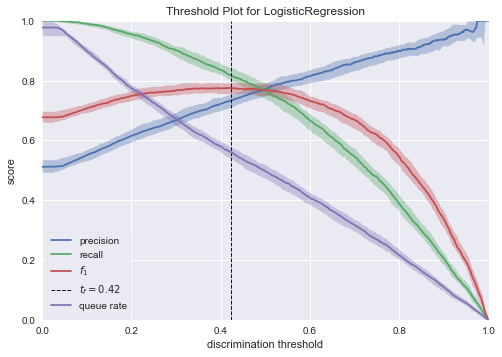

In [83]:
#SMOTE with Variation B
churnPrediction(logitB,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1982
         1.0       0.45      0.73      0.56       518

    accuracy                           0.76      2500
   macro avg       0.68      0.75      0.70      2500
weighted avg       0.82      0.76      0.78      2500

Accuracy   Score :  0.7616
Area under curve :  0.7505425275354639 



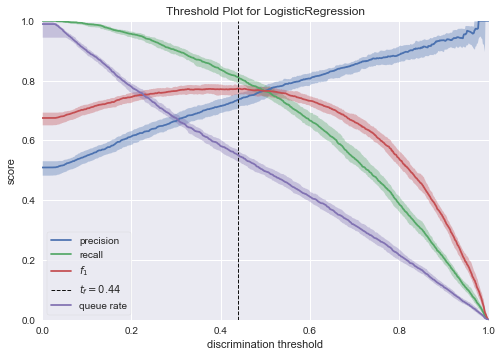

In [84]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()


rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in df.columns if i not in target_col],
                       "ranking" : rfe.ranking_,
                      })


cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#split data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
churnPrediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1982
         1.0       0.45      0.73      0.56       518

    accuracy                           0.76      2500
   macro avg       0.68      0.75      0.70      2500
weighted avg       0.82      0.76      0.78      2500

Accuracy   Score :  0.7616
Area under curve :  0.7505425275354639 



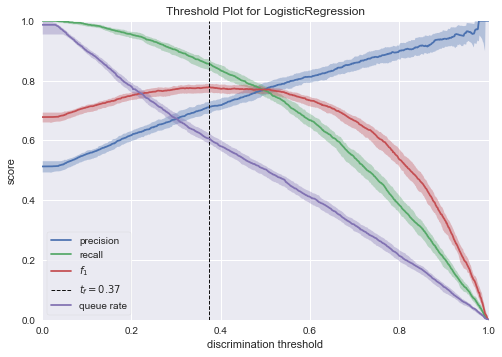

In [85]:
#RFE with Variation B
#applying model
churnPrediction(logitB,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

In [86]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in df.columns if i not in target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[2.28157806e+00 5.15399263e+01 2.89160398e+02 1.42514094e+02
 1.50040970e-01 1.18199414e+02 1.20902737e+00 5.49237052e+01
 2.25464426e+02 2.08672058e+01 1.69063641e+02 4.62775775e+02
 6.37239136e+02 2.34550810e+02 9.45449855e-01 5.70364074e-01
 9.41633178e-03]
P - Values
[1.30918607e-001 7.01557451e-013 7.57702890e-065 7.50711813e-033
 6.98496209e-001 1.56803624e-027 2.71524834e-001 1.25300579e-013
 5.81457176e-051 4.92250487e-006 1.18489502e-038 1.19629582e-102
 1.33164931e-140 6.06635843e-053 3.30880208e-001 4.50114279e-001
 9.22696388e-001]


In [88]:
# Uses the top 3 numerical and categorical features
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

features_cat  = score[score["feature_type"] == "Categorical"]["features"][:3].tolist()
features_num  = score[score["feature_type"] == "Numerical"]["features"][:3].tolist()
#Plotting Decision Tree Graph Function
def plot_decision_tree(columns,maximum_depth,criterion_type,
                       split_type,model_performance = None) :

    dtc_x = df_x[columns]
    dtc_y = df_y[target_col]
    
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth,
                                           splitter  = split_type,
                                           criterion = criterion_type,
                                          )
    dt_classifier.fit(dtc_x,dtc_y)
    

    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = columns, 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True))
    
    if model_performance == True :
        churnPrediction(dt_classifier,
                                 dtc_x,test_X[columns],
                                 dtc_y,test_Y,
                                 columns,"features",threshold_plot = True)
    display(graph)


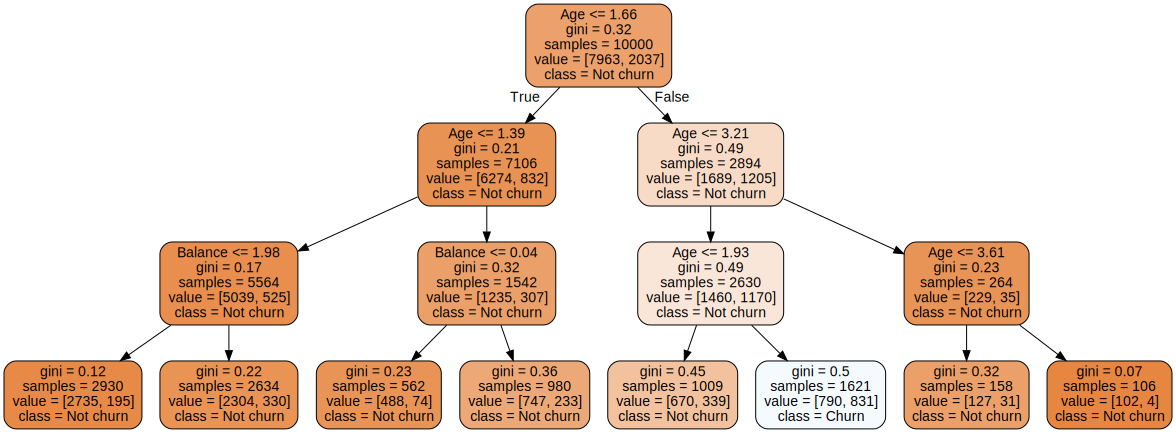

In [89]:
#Using Top 3 From Numerical Data
plot_decision_tree(features_num,3,"gini","best")
# Gini is for calculate impurity, to decide which one to be the root/node
# Gini = 1 - (probability of yes)^2 - (probablitiy of No)^2
#Value= [Churn, Not Churn]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      1982
         1.0       0.89      0.14      0.24       518

    accuracy                           0.82      2500
   macro avg       0.85      0.57      0.57      2500
weighted avg       0.83      0.82      0.76      2500

Accuracy   Score :  0.8176
Area under curve :  0.5662623846276723 



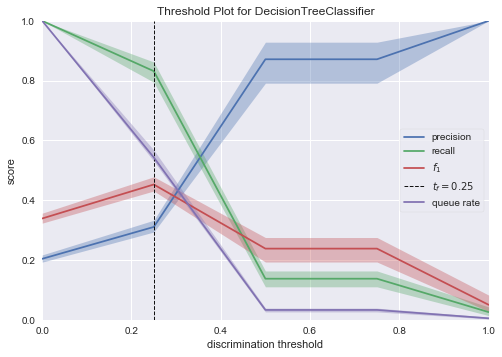

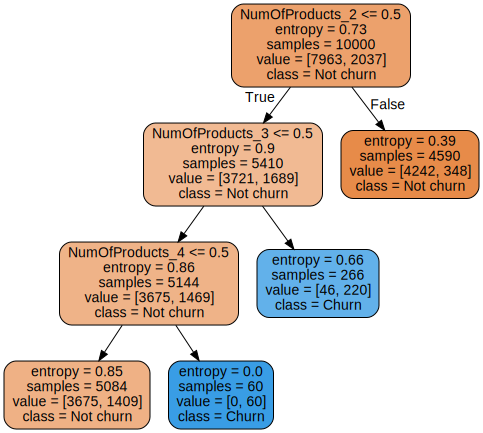

['NumOfProducts_3', 'NumOfProducts_2', 'NumOfProducts_4'] ['Age', 'Balance', 'CreditScore']


In [90]:
#Using Top 3 From Categorical Data
plot_decision_tree(features_cat,3,"entropy","best",
                   model_performance = True )
print(features_cat, features_num)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1982
         1.0       0.57      0.50      0.53       518

    accuracy                           0.82      2500
   macro avg       0.72      0.70      0.71      2500
weighted avg       0.81      0.82      0.81      2500

Accuracy   Score :  0.8172
Area under curve :  0.6993374735554353 



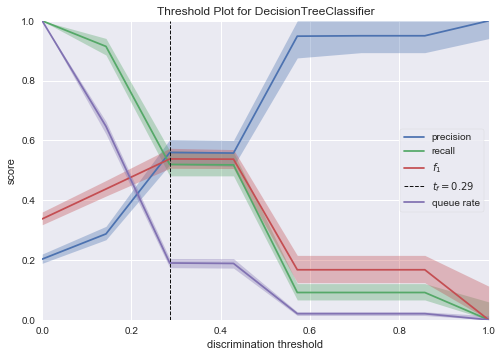

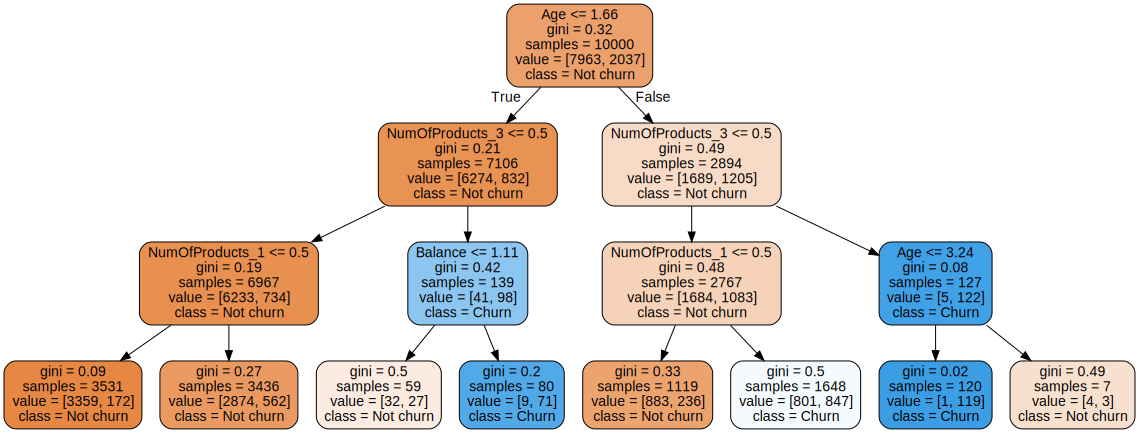

In [93]:
#using Age,NoP 3 and balance billing variables
columns = ['Age','NumOfProducts_3', 'Balance','NumOfProducts_4','NumOfProducts_1']

plot_decision_tree(columns,3,"gini","best",model_performance= True)

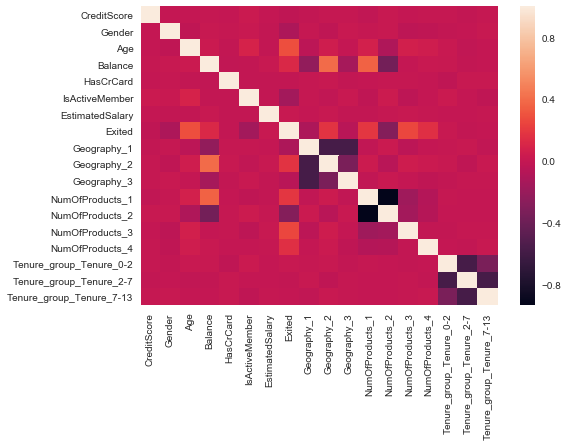

In [91]:
sns.heatmap(df.corr())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.89      0.75      0.82      1982
         1.0       0.40      0.64      0.50       518

    accuracy                           0.73      2500
   macro avg       0.65      0.70      0.66      2500
weighted avg       0.79      0.73      0.75      2500

Accuracy Score   :  0.7296
Area under curve :  0.6968508078497988


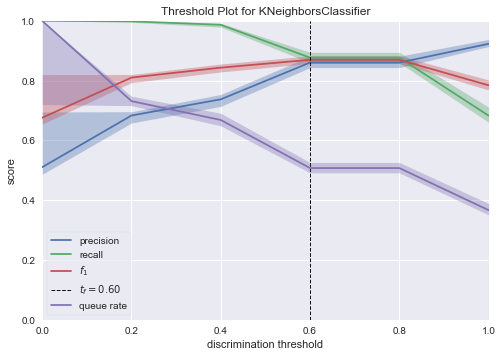

In [95]:
#Using KNNN to Smote
#New Function for model without Cols and Coefficients Variables
def churnPrediction1(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model .fit() ,predictions and probabilities
        algorithm.fit(training_x,training_y)
        predictions   = algorithm.predict(testing_x)
        probabilities = algorithm.predict_proba(testing_x)

    #Report
        print (algorithm)
        print ("\n Classification report : \n",classification_report(testing_y,predictions))
        print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
        
        #confusion matrix
        conf_matrix = confusion_matrix(testing_y,predictions)
       
        #roc_auc_score
        model_roc_auc = roc_auc_score(testing_y,predictions) 
        print ("Area under curve : ",model_roc_auc)
        fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #Plot Graphs
        #plot roc curve
        trace1 = go.Scatter(x = fpr,y = tpr,
                            name = "Roc : " + str(model_roc_auc),
                            line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                           )
        trace2 = go.Scatter(x = [0,1],y=[0,1],
                            line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                            dash = 'dot'))

        #plot confusion matrix(HeatMap)
        trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
                            y = ["Not churn","Churn"],
                            showscale  = False,colorscale = "Blues",name = "matrix",
                            xaxis = "x2",yaxis = "y2"
                           )

        layout = go.Layout(dict(title="Model performance" ,
                                autosize = False,height = 500,width = 800,
                                showlegend = False,
                                plot_bgcolor  = "rgb(243,243,243)",
                                paper_bgcolor = "rgb(243,243,243)",
                                xaxis = dict(title = "false positive rate",
                                             gridcolor = 'rgb(255, 255, 255)',
                                             domain=[0, 0.6],
                                             ticklen=5,gridwidth=2),
                                yaxis = dict(title = "true positive rate",
                                             gridcolor = 'rgb(255, 255, 255)',
                                             zerolinewidth=1,
                                             ticklen=5,gridwidth=2),
                                margin = dict(b=200),
                                xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                            gridcolor = 'rgb(255, 255, 255)'),
                                yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                               )
                      )
        data = [trace1,trace2,trace3]
        fig = go.Figure(data=data,layout=layout)

        py.iplot(fig)

        if threshold_plot == True : 
            visualizer = DiscriminationThreshold(algorithm)
            visualizer.fit(training_x,training_y)
            visualizer.poof()
            
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
churnPrediction1(knn,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = True)

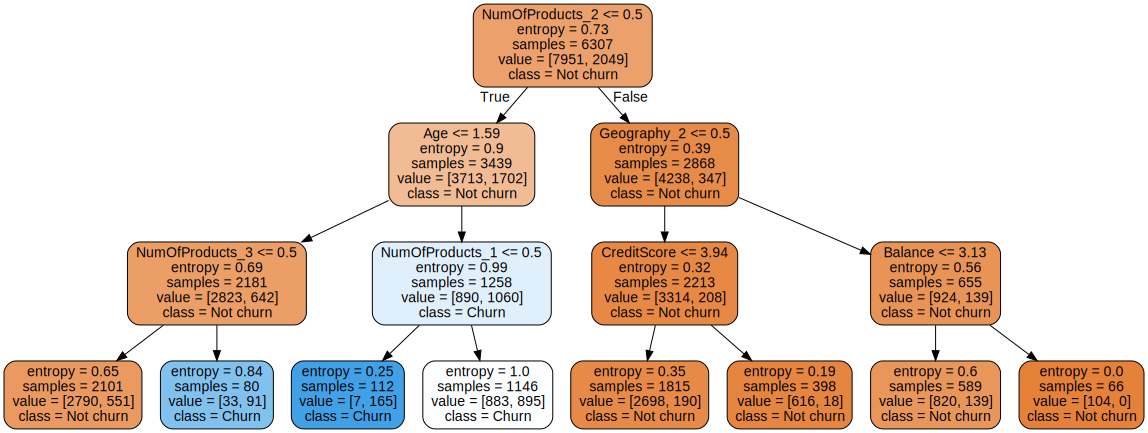

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.90      1982
         1.0       0.98      0.12      0.22       518

    accuracy                           0.82      2500
   macro avg       0.90      0.56      0.56      2500
weighted avg       0.85      0.82      0.76      2500

Accuracy   Score :  0.8176
Area under curve :  0.5605585403769058 



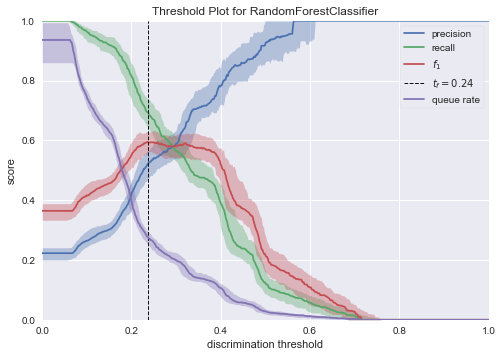

In [97]:
#Visualize Random Forest
from sklearn.ensemble import RandomForestClassifier

#Function for Random Forest
def plot_tree_randomforest(columns,nf_estimators,estimated_tree,maximum_depth,criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #Assign training and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,max_depth = maximum_depth,criterion = criterion_type)
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns, 
                            precision  = 2,
                            class_names=["Not churn","Churn"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        churnPrediction(rfc,rf_x,test_X[columns],rf_y,test_Y,columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col ] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

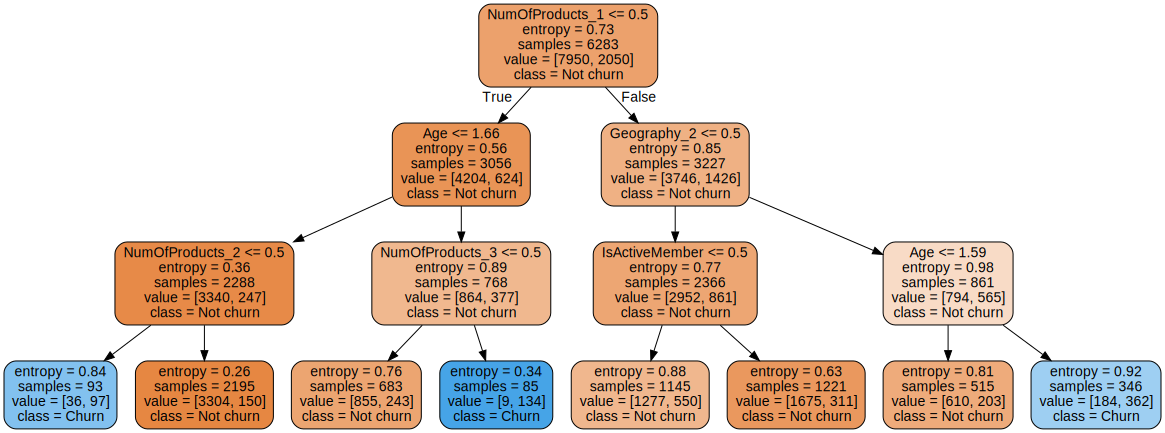

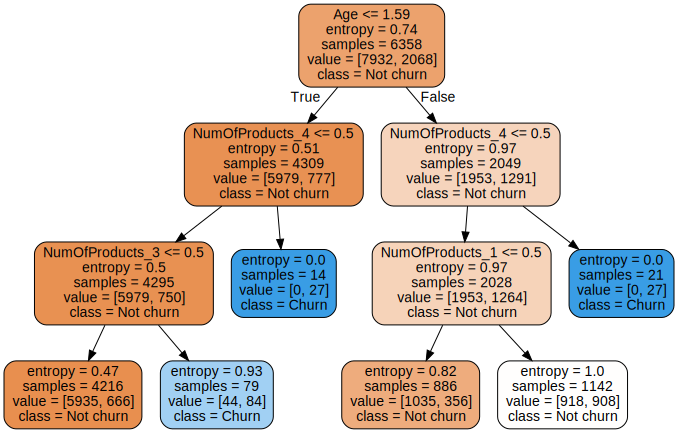

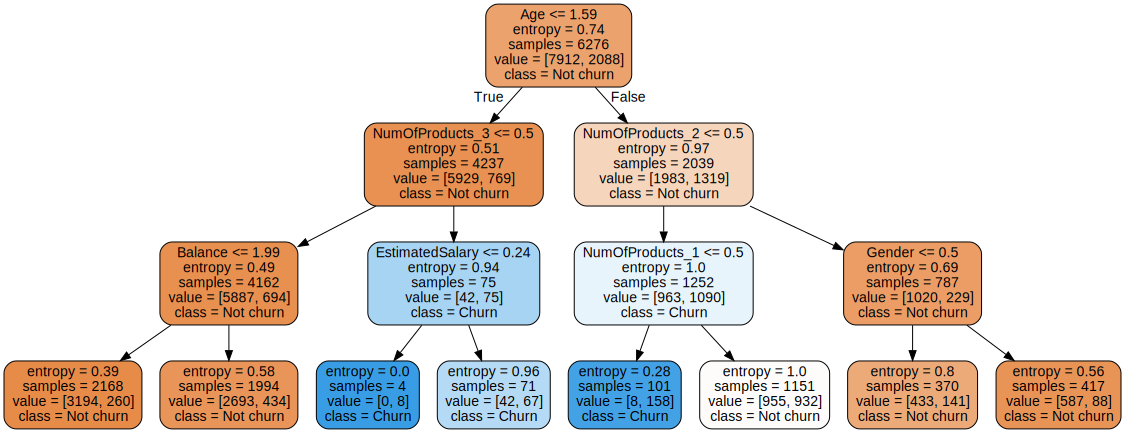

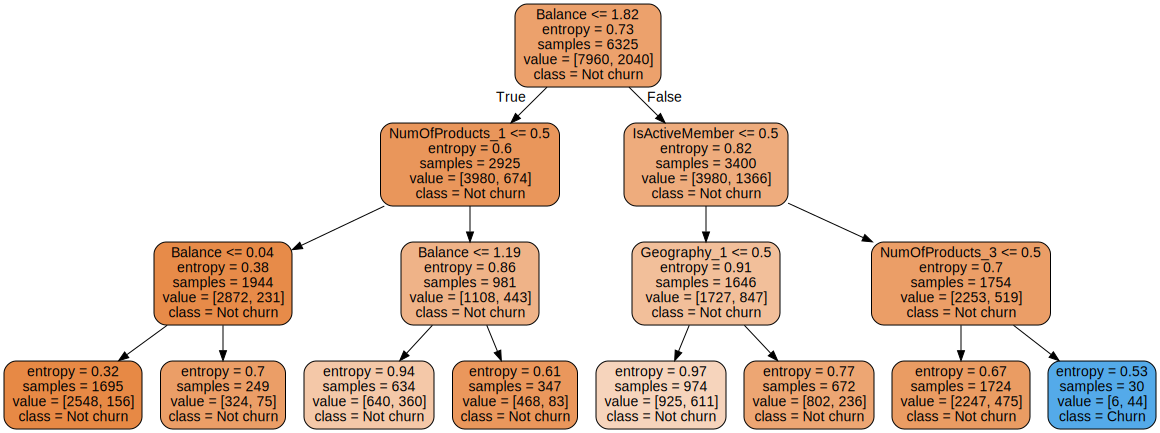

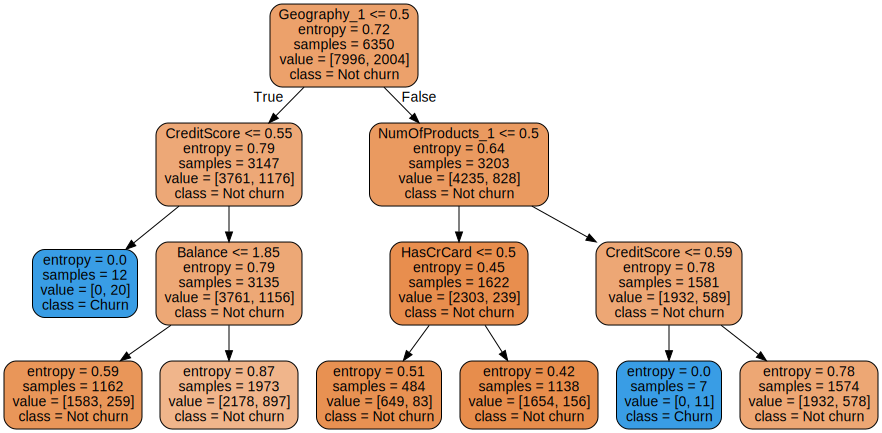

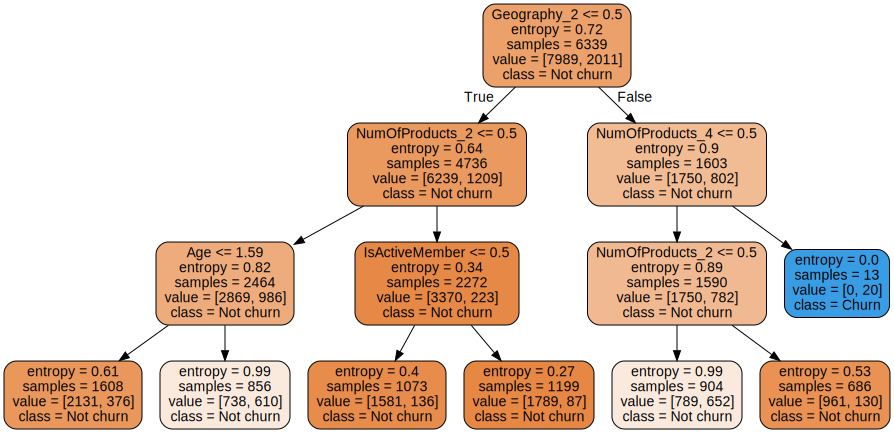

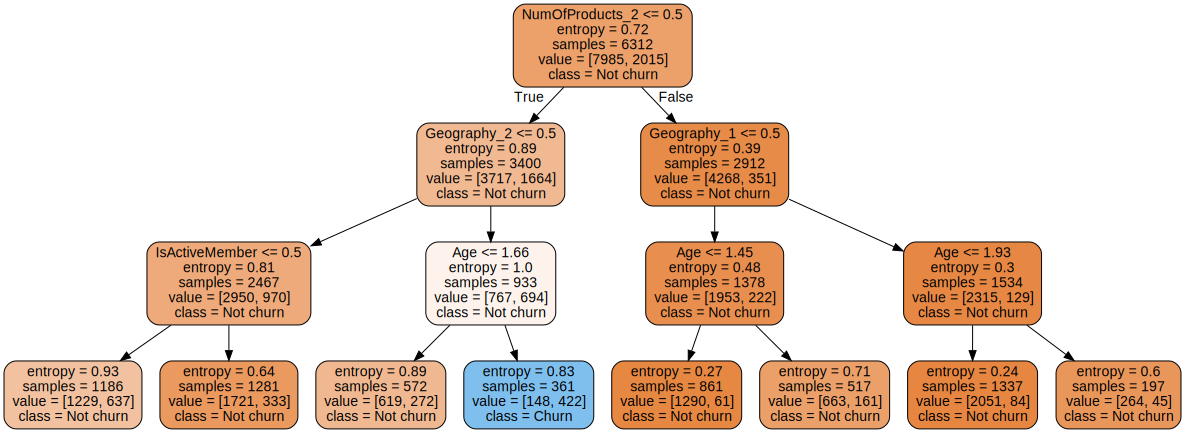

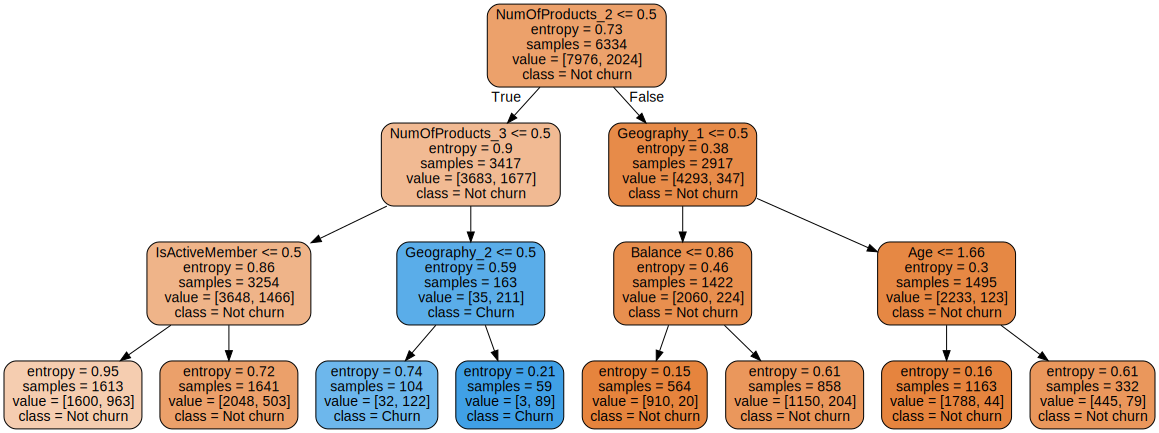

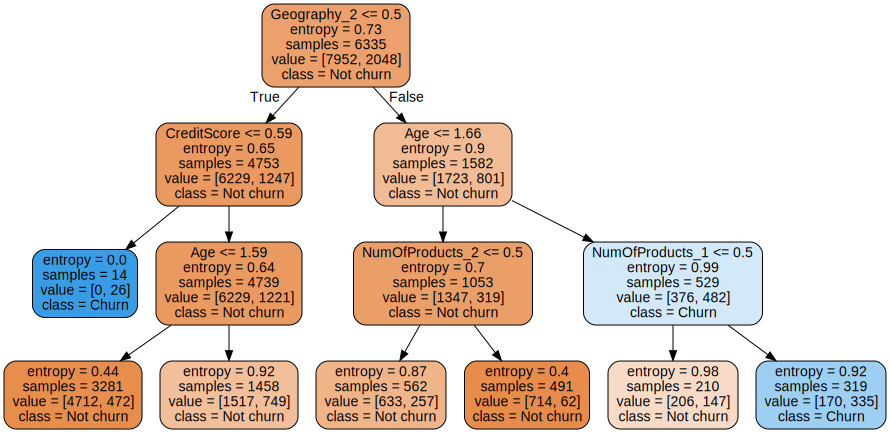

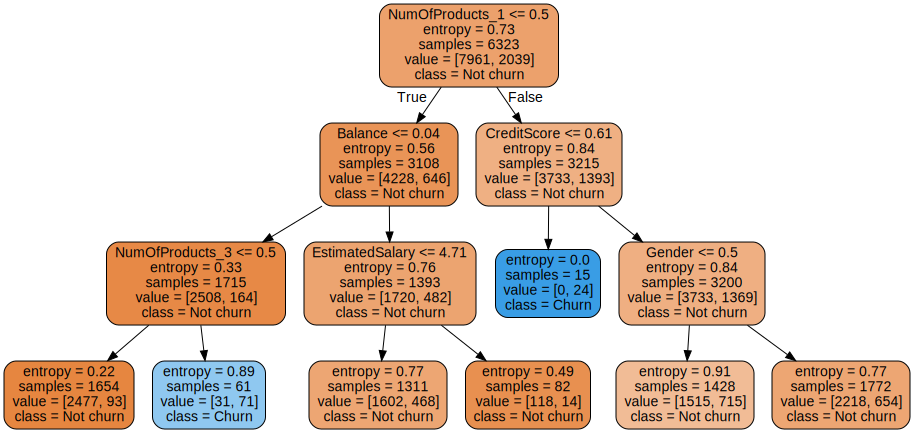

In [99]:
n = np.arange(0,10).tolist()
cols1 = [ i for i in train_X.columns if i not in target_col ] 
for i in n :
    plot_tree_randomforest(cols1,10,i,3,"entropy",model_performance=False)

In [100]:
idc_rfe[idc_rfe['rfe_support'] ==True]

,rfe_support,columns,ranking
1,True,Gender,1
2,True,Age,1
5,True,IsActiveMember,1
7,True,Geography_1,1
8,True,Geography_2,1
9,True,Geography_3,1
10,True,NumOfProducts_1,1
11,True,NumOfProducts_2,1
12,True,NumOfProducts_3,1
13,True,NumOfProducts_4,1


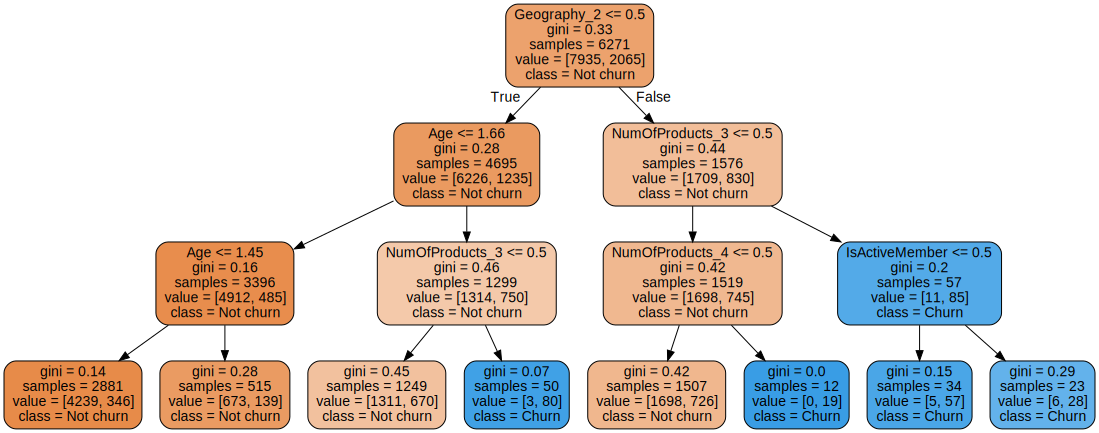

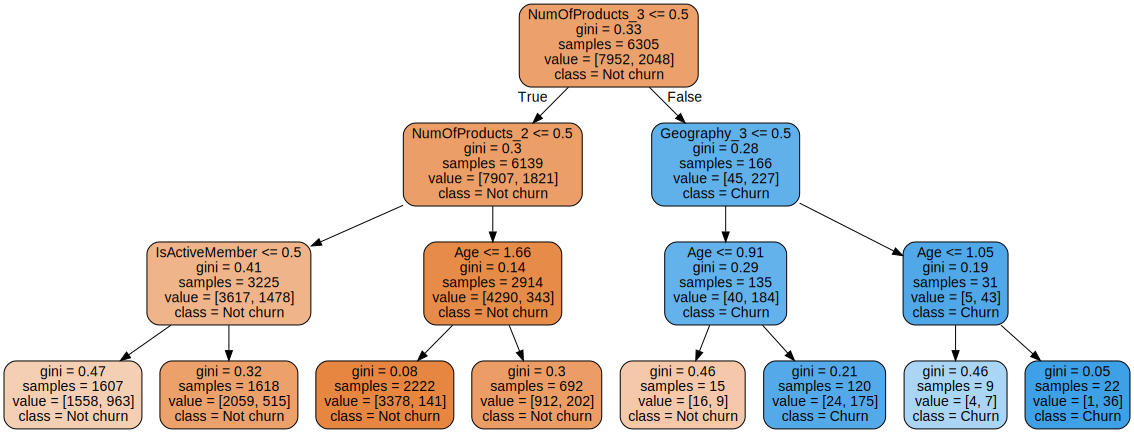

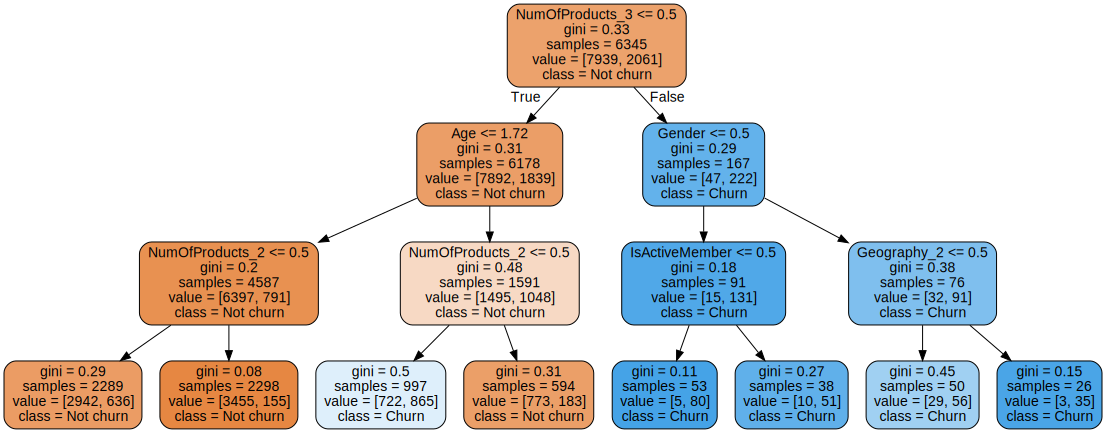

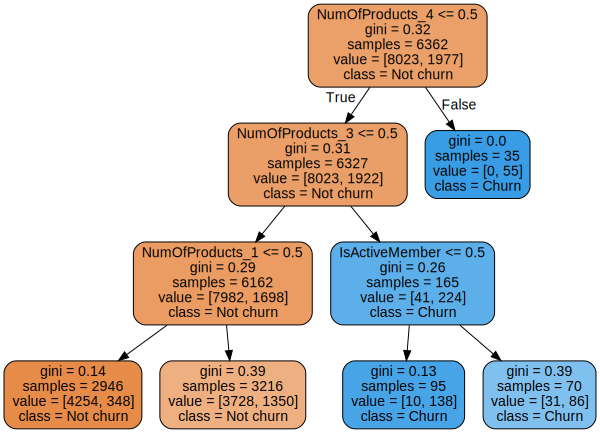

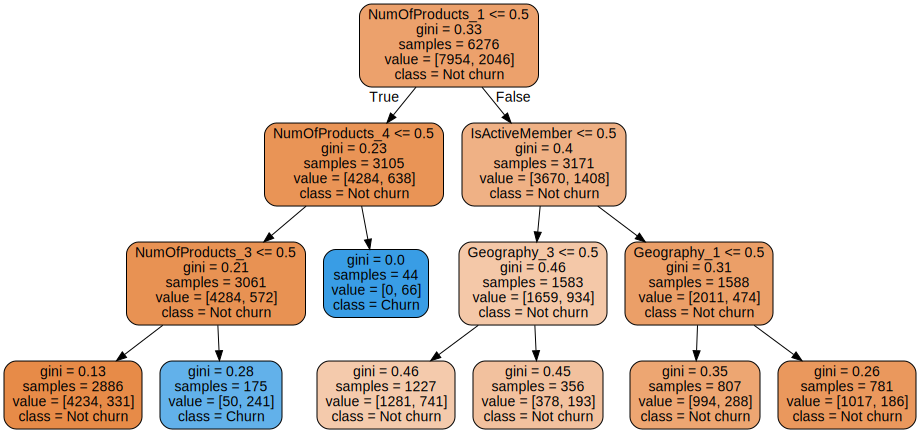

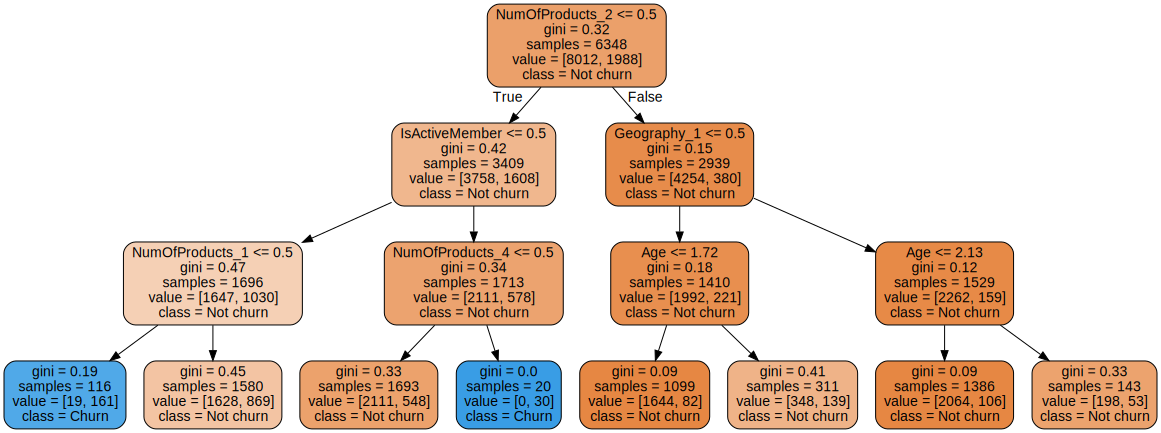

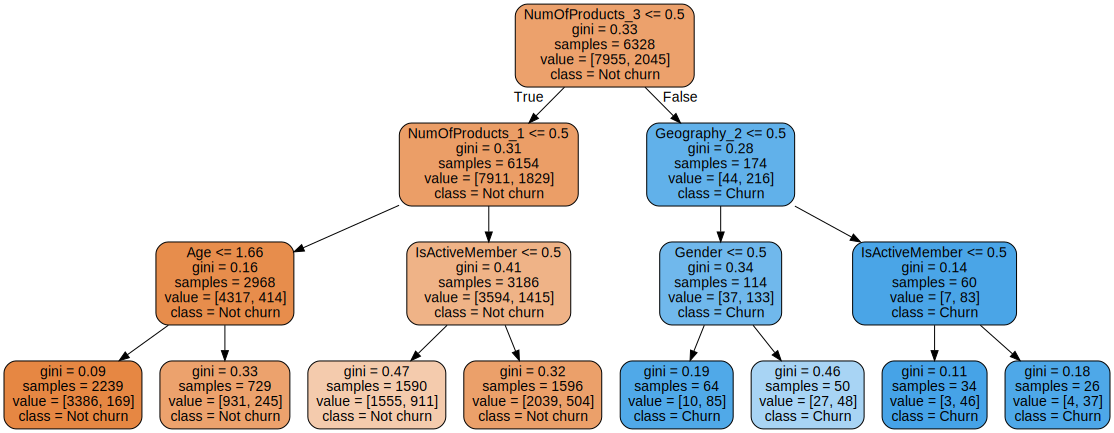

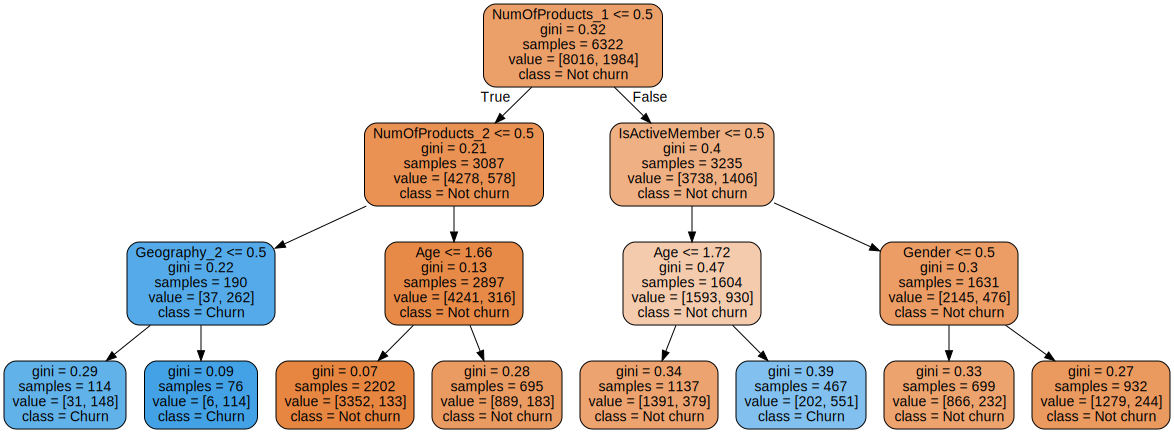

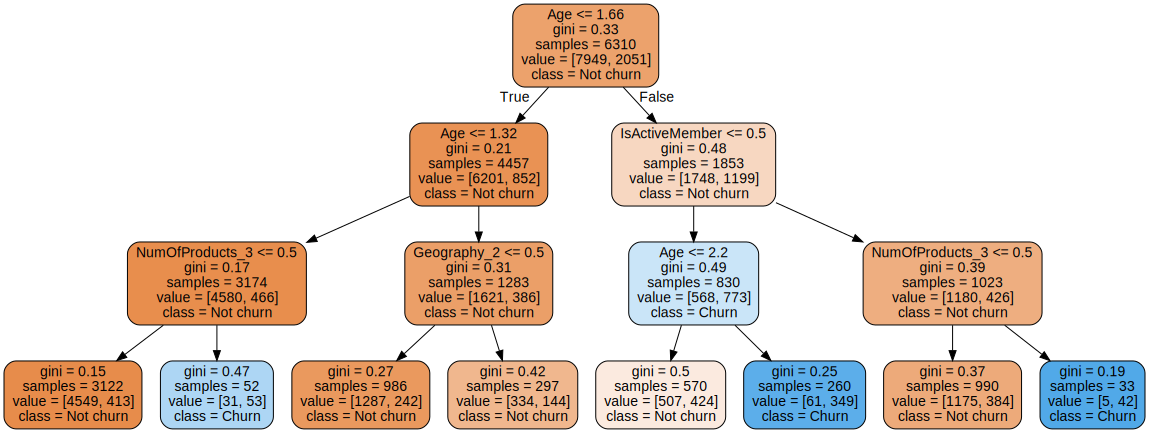

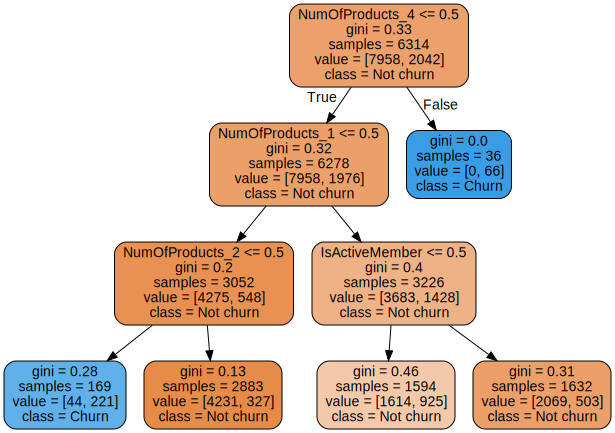

In [101]:
n = np.arange(0,10).tolist()
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist() 
for i in n :
    plot_tree_randomforest(cols,10,i,3,"gini",model_performance=False)

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      1982
         1.0       0.89      0.14      0.24       518

    accuracy                           0.82      2500
   macro avg       0.85      0.57      0.57      2500
weighted avg       0.83      0.82      0.76      2500

Accuracy Score   :  0.8176
Area under curve :  0.5662623846276723


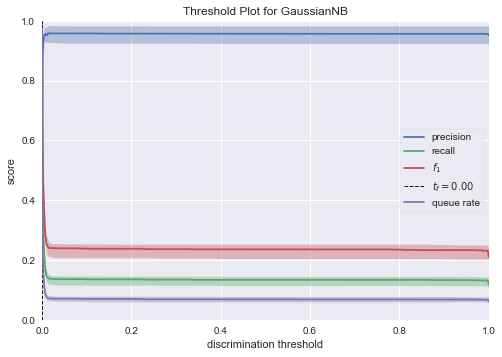

In [102]:
#Gausian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)
churnPrediction1(gnb,os_smote_X,test_X,os_smote_Y,test_Y)

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      1982
         1.0       0.89      0.14      0.24       518

    accuracy                           0.82      2500
   macro avg       0.85      0.57      0.57      2500
weighted avg       0.83      0.82      0.76      2500

Accuracy Score   :  0.8176
Area under curve :  0.5662623846276723


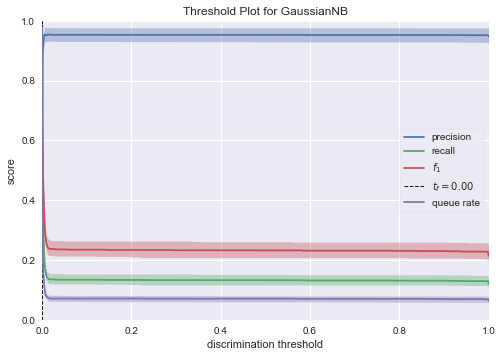

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1982
         1.0       0.46      0.75      0.57       518

    accuracy                           0.76      2500
   macro avg       0.69      0.76      0.70      2500
weighted avg       0.82      0.76      0.78      2500

Accuracy   Score :  0.7636
Area under curve :  0.7567947434244104 



In [105]:
#SVM
from sklearn.svm import SVC

#Support vector classifierfrom sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)

churnPrediction1(gnb,os_smote_X,test_X,os_smote_Y,test_Y)
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,tol=0.001, verbose=False)

cols = [i for i in df.columns if i not in target_col]
churnPrediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

In [104]:
#tuning parameters for support vector machine
#Support vector clasifier
#using non-linear hyper plane("rbf")

svc_rbf  = SVC(C=1.0, kernel='rbf', 
               degree= 3, gamma=1.0, 
               coef0=0.0, shrinking=True,
               probability=True,tol=0.001,
               cache_size=200, class_weight=None,
               verbose=False,max_iter= -1,
               random_state=None)

churnPrediction1(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = False)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1982
         1.0       0.54      0.43      0.48       518

    accuracy                           0.80      2500
   macro avg       0.70      0.67      0.68      2500
weighted avg       0.79      0.80      0.80      2500

Accuracy Score   :  0.8048
Area under curve :  0.6665627715072718


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1982
         1.0       0.62      0.53      0.57       518

    accuracy                           0.83      2500
   macro avg       0.75      0.72      0.73      2500
weighted avg       0.83      0.83      0.83      2500

Accuracy   Score :  0.8336
Area under curve :  0.7196622887843875 



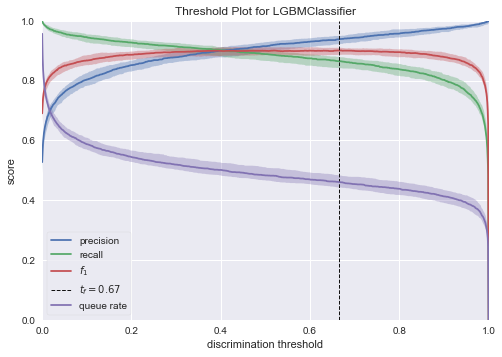

In [108]:
#Light GBM Classiier
from lightgbm import LGBMClassifier

lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

cols = [i for i in df.columns if i not in target_col]
churnPrediction(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1982
         1.0       0.62      0.53      0.57       518

    accuracy                           0.84      2500
   macro avg       0.75      0.72      0.74      2500
weighted avg       0.83      0.84 

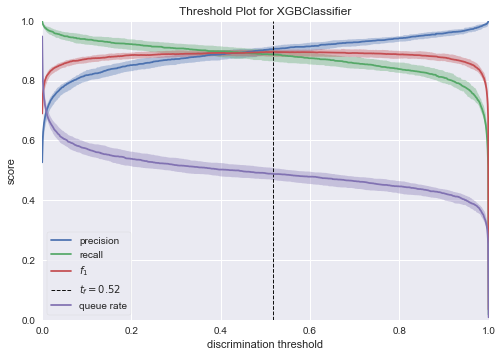

In [109]:
#XXGB Clasifier
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None,objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

#min_child_weight=1 for Cover; means minimum leaf is 1

churnPrediction(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.91      0.85      0.88      1982
         1.0       0.53      0.67      0.59       518

    accuracy                           0.81      2500
   macro avg       0.72      0.76      0.74      2500
weighted avg       0.83      0.81      0.82      2500

Accuracy   Score :  0.8108
Area under curve :  0.7580434333713849 



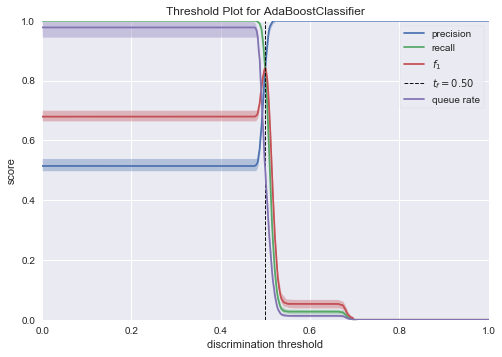

In [110]:
#AdaBoost 

from sklearn.ensemble import AdaBoostClassifier
adaB = AdaBoostClassifier()
churnPrediction(adaB,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

## Model Evaluation

In [111]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Log Regres")
model1_1 = model_report(logitB,train_X,test_X,train_Y,test_Y,
                         "Log Reg B")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LogReg(SMOTE)")
model2_2 = model_report(logitB,train_X,test_X,train_Y,test_Y,"LogReg(SMOTE)B")

model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "LogReg(RFE)")
model3_3 = model_report(logitB,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "LogReg(RFE)B")

decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )
model4 = model_report(decision_tree,train_X,test_X,train_Y,test_Y,
                      "Decision Tree")
model5 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,
                      "KNN Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model6 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
model7 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model8 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier Linear")
model9 = model_report(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier RBF")
model10 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")
model11 = model_report(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier")
model12 = model_report(adaB,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Ada Boost")

#concat all models
model_performances = pd.concat([model1,model1_1,model2,model2_2,model3,model3_3,
                                model4,model5,model6,
                                model7,model8,model9,
                                model10,model11,model12],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

In [112]:
#Compare Model Metrices
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

ValueError: X has 17 features per sample; expecting 10

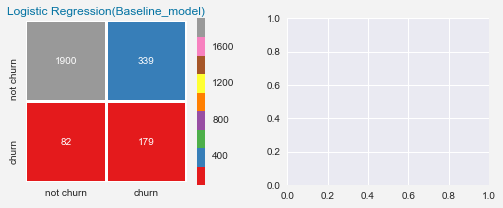

In [117]:
##Compare Model Confusion Matrix
logit_smoteB=logitB
lst    = [logit,logitB,logit_smote,logit_smoteB,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc,adaB]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(Baseline_model) variation B','Logistic Regression(SMOTE)','Logistic Regression(SMOTE) Var. B',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier','ADA Boost']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

In [ ]:
## Compare ROC of models
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(test_Y,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

ValueError: X has 17 features per sample; expecting 10

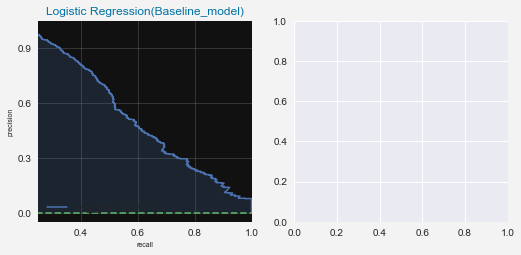

In [118]:
## Precision Recall Curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


fig = plt.figure(figsize=(13,17))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    recall,precision,thresholds = precision_recall_curve(test_Y,probabilities[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
             label = ("avg_pcn : " + 
                      str(np.around(average_precision_score(test_Y,predictions),3))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = "lower left",
               prop = {"size" : 10})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xlabel("recall",fontsize =7)
    plt.ylabel("precision",fontsize =7)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))